In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, BatchNormalization, Conv3D

In [55]:
from PIL import Image
import os

# Directory paths
input_dir = '/content/drive/MyDrive/LSTM_TEST/DATA/HAERBING'
output_dir = '/content/drive/MyDrive/LSTM_MODEL/HAERBING'
num_files = len([f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))])

print(num_files)

21


In [56]:
for filename in os.listdir(input_dir):
    if filename.endswith('.tif'):
        img = Image.open(os.path.join(input_dir, filename))
        img_gray = img.convert("L")
        base_filename = os.path.splitext(filename)[0]  # remove .tif from filename
        img_gray.save(os.path.join(output_dir, base_filename + '.jpg'), 'JPEG')

In [62]:
from PIL import Image
import numpy as np
import os

def load_image_sequences(folder, sequence_length):

    images = []
    filenames = sorted(os.listdir(folder))
    if not filenames:
        return None  # Return None if the folder is empty

    # Open the first image and get its size
    first_image = Image.open(os.path.join(folder, filenames[0]))
    target_size = (first_image.size[0]//2, first_image.size[1]//2)
    # target_size = first_image.size

    for filename in filenames:
        img = Image.open(os.path.join(folder, filename)).resize(target_size)
        images.append(np.array(img))

    # Convert the list of images into a numpy array
    images = np.array(images)

    # Normalize pixel values to [0, 1]
    images = images.astype('float32') / 255.0

    # Reshape into 5D tensor for ConvLSTM
    sequences = np.array([images[i:i+sequence_length] for i in range(images.shape[0] - sequence_length)])

    return sequences[..., np.newaxis]  # add a dimension for grayscale channel


folder = "/content/drive/MyDrive/LSTM_MODEL/HAERBING"
sequences = load_image_sequences(folder, 4)
print(sequences.shape)

(17, 4, 156, 274, 1)


In [63]:
# Dimensions of your input images (Height, Width, Channels)
input_shape = (3, 156, 274, 1)  # 3 frames of grayscale images

# Define the ConvLSTM model
model = Sequential()

# Add a ConvLSTM layer
model.add(ConvLSTM2D(filters=96, kernel_size=(3, 3), input_shape=input_shape, padding='same', return_sequences=True))

# Add a batch normalization layer
model.add(BatchNormalization())

# Add another ConvLSTM layer
model.add(ConvLSTM2D(filters=96, kernel_size=(3, 3), padding='same', return_sequences=True))

# Add a batch normalization layer
model.add(BatchNormalization())

# Add another ConvLSTM layer
model.add(ConvLSTM2D(filters=96, kernel_size=(3, 3), padding='same', return_sequences=True))

# Add a batch normalization layer
model.add(BatchNormalization())

# Add a Conv3D layer to generate the predicted next frame
model.add(Conv3D(filters=1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same', data_format='channels_last'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_18 (ConvLSTM2D)  (None, 3, 156, 274, 96)  335616    
                                                                 
 batch_normalization_18 (Bat  (None, 3, 156, 274, 96)  384       
 chNormalization)                                                
                                                                 
 conv_lstm2d_19 (ConvLSTM2D)  (None, 3, 156, 274, 96)  663936    
                                                                 
 batch_normalization_19 (Bat  (None, 3, 156, 274, 96)  384       
 chNormalization)                                                
                                                                 
 conv_lstm2d_20 (ConvLSTM2D)  (None, 3, 156, 274, 96)  663936    
                                                                 
 batch_normalization_20 (Bat  (None, 3, 156, 274, 96) 

In [64]:
def generate_targets(sequences):
    # Remove the first frame from each sequence
    targets = sequences[:, 1:, :, :, :]

    # Remove the last frame from each sequence
    sequences = sequences[:, :-1, :, :, :]

    return sequences, targets

sequences, targets = generate_targets(sequences)


In [65]:
split_idx = 15

sequences_train = sequences[:split_idx]
sequences_val = sequences[split_idx:split_idx+5]
targets_train = targets[:split_idx]
targets_val = targets[split_idx:split_idx+5]


In [66]:
# Assuming 'model' is your ConvLSTM2D model

# Train the model
history = model.fit(
    sequences_train,
    targets_train,
    validation_data=(sequences_val, targets_val),
    batch_size=2,
    epochs=100
)


Epoch 1/100
8/8 [==============================] - 15s 440ms/step - loss: 0.0810 - val_loss: 0.2405
Epoch 2/100
8/8 [==============================] - 2s 238ms/step - loss: 4.3216e-04 - val_loss: 0.2528
Epoch 3/100
8/8 [==============================] - 2s 251ms/step - loss: 3.7984e-04 - val_loss: 0.2557
Epoch 4/100
8/8 [==============================] - 2s 277ms/step - loss: 3.7490e-04 - val_loss: 0.2511
Epoch 5/100
8/8 [==============================] - 2s 261ms/step - loss: 3.5958e-04 - val_loss: 0.2422
Epoch 6/100
8/8 [==============================] - 2s 237ms/step - loss: 3.1380e-04 - val_loss: 0.2315
Epoch 7/100
8/8 [==============================] - 2s 246ms/step - loss: 3.0250e-04 - val_loss: 0.2214
Epoch 8/100
8/8 [==============================] - 2s 246ms/step - loss: 2.9142e-04 - val_loss: 0.2122
Epoch 9/100
8/8 [==============================] - 2s 247ms/step - loss: 2.6453e-04 - val_loss: 0.2046
Epoch 10/100
8/8 [==============================] - 2s 236ms/step - loss: 1.

In [29]:
model.save("/content/drive/MyDrive/LSTM_MODEL/params/SHANGHAI/batch2_model.h5")

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/LSTM_MODEL/HANGZHOU/layers_model.h5')


In [67]:
# Load and prepare your image sequence
folder = "/content/drive/MyDrive/LSTM_TEST/HAERBING"
predicted_sequences = load_image_sequences(folder, 3)  # assuming you're using the function defined earlier
print(predicted_sequences.shape)
model_output = model.predict(predicted_sequences)






(1, 3, 156, 274, 1)


1/1 [==============================] - 1s 877ms/step


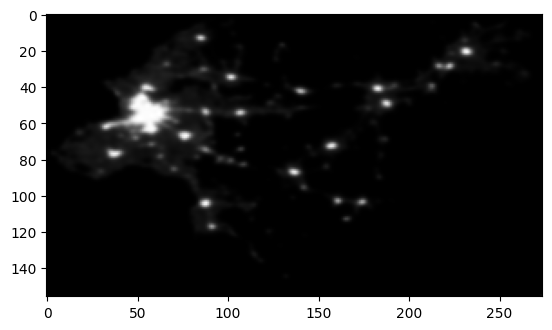

In [68]:
import matplotlib.pyplot as plt
vis = model_output[0]
plt.imshow(vis[0, :, :, 0], cmap='gray')
plt.show()